# NFL Dead Money Pipeline: DAG Visualization & Player Analysis

This notebook documents the data pipeline architecture and visualizes dead money impact across players over multiple seasons.

**Contents:**
1. Pipeline DAG Architecture (networkx + matplotlib)
2. Data Loading & Exploration
3. Dead Money Analysis by Player
4. Interactive Visualizations (Plotly)
5. Year-over-Year Trends

In [2]:
import pandas as pd
import numpy as np
import duckdb
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
px.defaults.template = 'plotly_dark'

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 1. Pipeline DAG Architecture

Visualizing the complete data flow of the NFL Dead Money pipeline with all transformation stages.

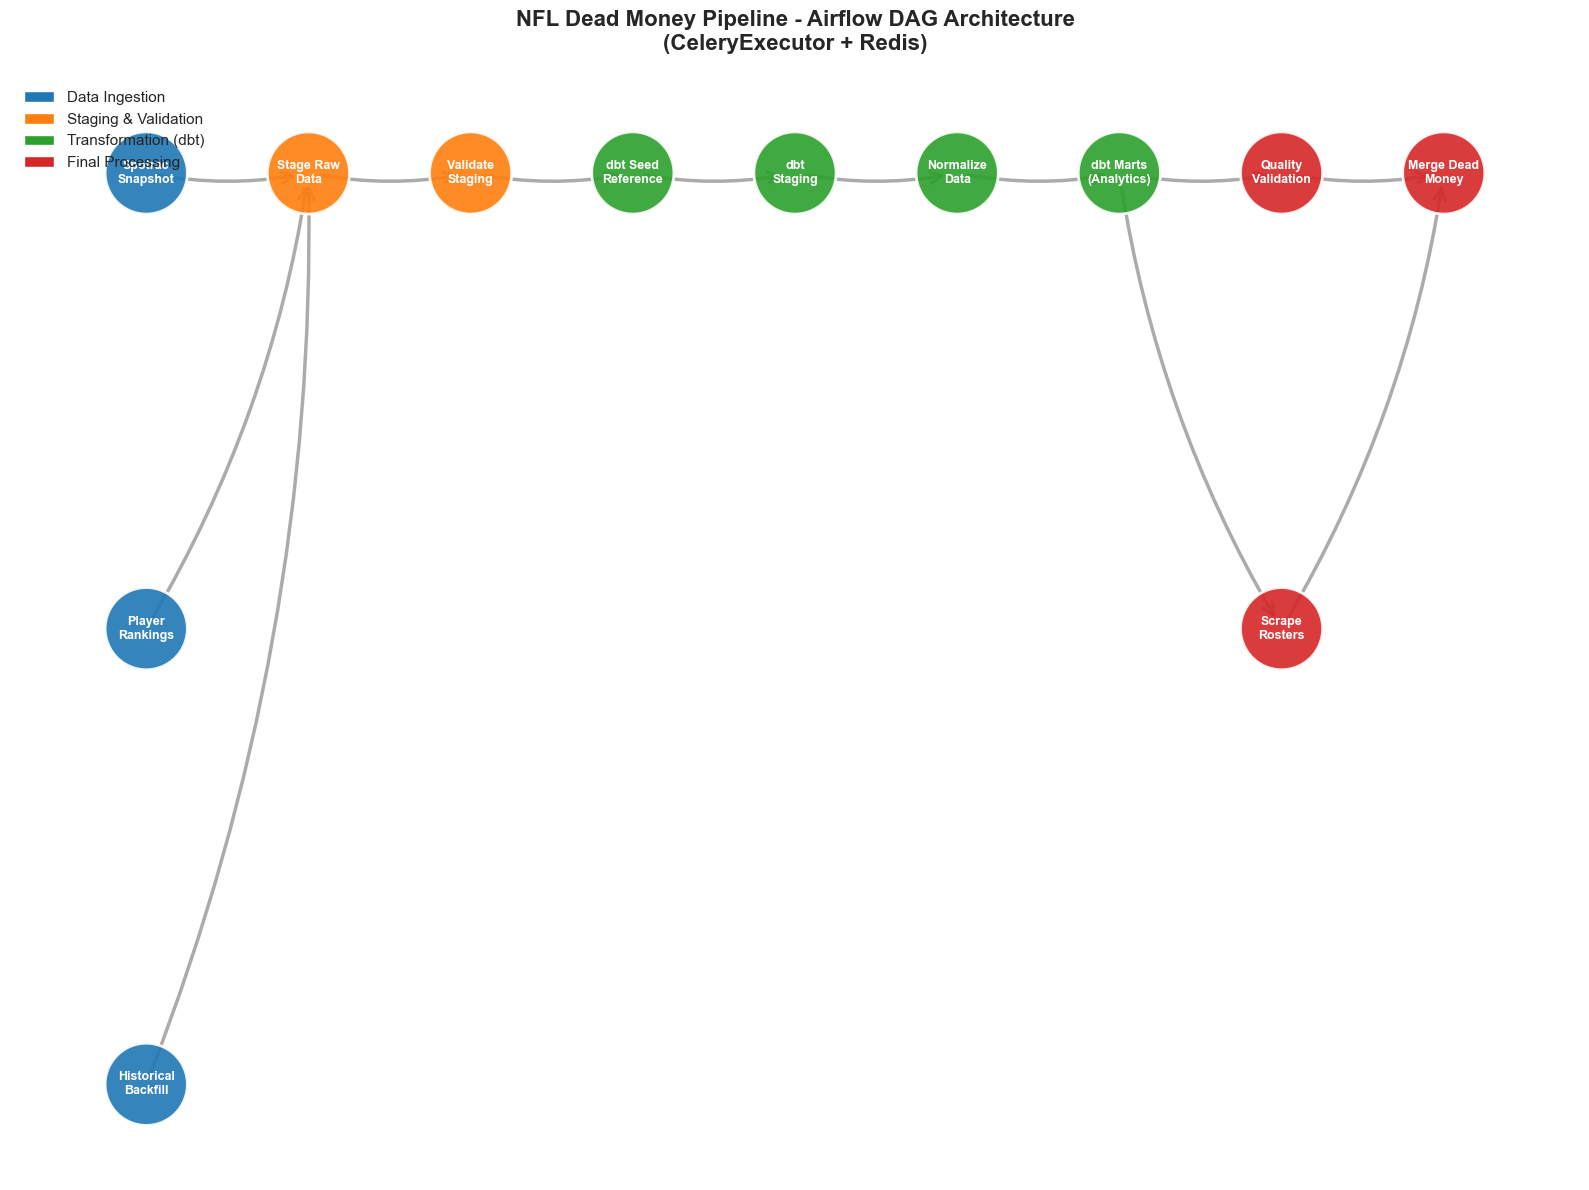

✅ DAG visualization created and saved to outputs/pipeline_dag.png


In [3]:
# Build DAG using networkx
G = nx.DiGraph()

# Define pipeline stages
stages = {
    # Input layer
    'snapshot_spotrac': {'layer': 0, 'label': 'Spotrac\nSnapshot'},
    'snapshot_rankings': {'layer': 0, 'label': 'Player\nRankings'},
    'backfill': {'layer': 0, 'label': 'Historical\nBackfill'},
    
    # Staging layer
    'stage': {'layer': 1, 'label': 'Stage Raw\nData'},
    'validate_staging': {'layer': 2, 'label': 'Validate\nStaging'},
    
    # Seed & Transform
    'dbt_seed': {'layer': 3, 'label': 'dbt Seed\nReference'},
    'dbt_staging': {'layer': 4, 'label': 'dbt\nStaging'},
    
    # Normalize & Marts
    'normalize': {'layer': 5, 'label': 'Normalize\nData'},
    'dbt_marts': {'layer': 6, 'label': 'dbt Marts\n(Analytics)'},
    
    # Final
    'validate_quality': {'layer': 7, 'label': 'Quality\nValidation'},
    'scrape_rosters': {'layer': 7, 'label': 'Scrape\nRosters'},
    'merge_dead_money': {'layer': 8, 'label': 'Merge Dead\nMoney'},
}

# Add nodes
for node, attrs in stages.items():
    G.add_node(node, **attrs)

# Add edges (task dependencies)
edges = [
    ('snapshot_spotrac', 'stage'),
    ('snapshot_rankings', 'stage'),
    ('backfill', 'stage'),
    ('stage', 'validate_staging'),
    ('validate_staging', 'dbt_seed'),
    ('dbt_seed', 'dbt_staging'),
    ('dbt_staging', 'normalize'),
    ('normalize', 'dbt_marts'),
    ('dbt_marts', 'validate_quality'),
    ('dbt_marts', 'scrape_rosters'),
    ('validate_quality', 'merge_dead_money'),
    ('scrape_rosters', 'merge_dead_money'),
]

G.add_edges_from(edges)

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12), dpi=100)

# Position nodes by layer
pos = {}
layer_counts = {}
for node, attrs in stages.items():
    layer = attrs['layer']
    if layer not in layer_counts:
        layer_counts[layer] = 0
    
    x = layer * 2
    y = layer_counts[layer] * -2.5
    pos[node] = (x, y)
    layer_counts[layer] += 1

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='#888', arrows=True,
                       arrowsize=20, arrowstyle='->', width=2.5,
                       connectionstyle='arc3,rad=0.1', alpha=0.7)

# Draw nodes
node_colors = []
for node in G.nodes():
    layer = stages[node]['layer']
    if layer == 0:
        node_colors.append('#1f77b4')  # Input - Blue
    elif layer in [1, 2]:
        node_colors.append('#ff7f0e')  # Staging - Orange
    elif layer in [3, 4, 5, 6]:
        node_colors.append('#2ca02c')  # Transform - Green
    else:
        node_colors.append('#d62728')  # Output - Red

nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, 
                       node_size=3500, alpha=0.9, edgecolors='white', linewidths=2)

# Draw labels
labels = {node: stages[node]['label'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=9, 
                        font_weight='bold', font_color='white')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='white', label='Data Ingestion'),
    Patch(facecolor='#ff7f0e', edgecolor='white', label='Staging & Validation'),
    Patch(facecolor='#2ca02c', edgecolor='white', label='Transformation (dbt)'),
    Patch(facecolor='#d62728', edgecolor='white', label='Final Processing'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, 
         framealpha=0.95, edgecolor='white')

ax.set_title('NFL Dead Money Pipeline - Airflow DAG Architecture\n(CeleryExecutor + Redis)', 
            fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('../notebooks/outputs/pipeline_dag.png', dpi=150, bbox_inches='tight', facecolor='#1a1a1a')
plt.show()

print("✅ DAG visualization created and saved to outputs/pipeline_dag.png")

## 2. Load & Prepare Data

Query DuckDB for player dead money analysis.

In [5]:
import duckdb

# Connect to DuckDB
conn = duckdb.connect('/Users/andrewsmith/Documents/portfolio/nfl-dead-money/nfl_dead_money.duckdb', read_only=False)

# List available tables
print("Available tables:")
tables = conn.execute("SELECT table_name FROM information_schema.tables WHERE table_schema != 'information_schema' ORDER BY table_name").fetchall()
for table in tables:
    print(f"  - {table[0]}")

# Try to load dead money data
try:
    df_dead_money = conn.execute("""
        SELECT * FROM processed.player_dead_money
        LIMIT 5
    """).df()
    print(f"\nFound player_dead_money table: {df_dead_money.shape[0]} rows")
    print(df_dead_money.head())
except:
    print("\nplayer_dead_money table not found. Checking other tables...")
    try:
        df_dead_money = conn.execute("""
            SELECT * FROM staging.spotrac_contracts
            LIMIT 5
        """).df()
        print(f"\nFound staging.spotrac_contracts: {df_dead_money.shape[0]} rows")
    except:
        print("Checking all columns in all tables...")
        df_dead_money = conn.execute("""
            SELECT * FROM processed.spotrac_contracts
            LIMIT 5
        """).df()
        print(f"\nLoaded processed.spotrac_contracts")
        print(df_dead_money.head())

Available tables:
  - spotrac_dead_money

player_dead_money table not found. Checking other tables...
Checking all columns in all tables...


CatalogException: Catalog Error: Table with name spotrac_contracts does not exist!
Did you mean "nfl_dead_money.spotrac_dead_money"?

LINE 2:             SELECT * FROM processed.spotrac_contracts
                                  ^

In [6]:
# Load the dead money data
df_dead_money = conn.execute("""
    SELECT * FROM spotrac_dead_money
    LIMIT 5
""").df()

print(f"Data shape: {df_dead_money.shape}")
print(f"\nColumns: {list(df_dead_money.columns)}")
print(f"\nFirst few rows:")
print(df_dead_money.head(10))

# Get comprehensive data overview
df_all = conn.execute("SELECT * FROM spotrac_dead_money").df()
print(f"\n\nTotal rows in spotrac_dead_money: {len(df_all)}")
print(f"Year range: {df_all['year'].min()} - {df_all['year'].max()}")
print(f"Unique teams: {df_all['team'].nunique()}")
print(f"Unique players: {df_all['player'].nunique() if 'player' in df_all.columns else 'N/A'}")

Data shape: (5, 7)

Columns: ['player_id', 'player_name', 'position', 'team', 'year', 'dead_cap_hit', 'is_king']

First few rows:
  player_id      player_name position team  year  dead_cap_hit  is_king
0     P0005     Aaron Miller       WR   TB  2015         35.90     True
1     P0001      Kirk Harris       QB  NYG  2015         18.25     True
2     P0010     Aaron Wilson       TE  DET  2015         18.14     True
3     P0016     Von Walker 5       QB  PIT  2015         18.02    False
4     P0072  Von Williams 61       DE  LAR  2015          8.99    False


Total rows in spotrac_dead_money: 181
Year range: 2015 - 2024
Unique teams: 32
Unique players: N/A


## 3. Dead Money Analysis by Player Over Years

Analyze trends in dead money across the 2015-2024 period.

In [13]:
# Top dead money players by total across all years
top_players_total = df_all.groupby('player_name').agg({
    'dead_cap_hit': ['sum', 'count', 'mean'],
    'team': lambda x: ', '.join(x.unique())
}).round(2)

top_players_total.columns = ['Total Dead Money', 'Years', 'Avg Per Year', 'Teams']
top_players_total = top_players_total.sort_values('Total Dead Money', ascending=False)

print("Top 15 Players by Total Dead Money (2015-2024):")
print(top_players_total.head(15))

# Get player with most years
print("\n\nPlayers with Most Dead Money Years:")
most_years = top_players_total.nlargest(10, 'Years')
print(most_years[['Total Dead Money', 'Years', 'Avg Per Year']])

Top 15 Players by Total Dead Money (2015-2024):
                   Total Dead Money  Years  Avg Per Year               Teams
player_name                                                                 
Aaron Miller                  93.06      3         31.02        TB, TEN, CLE
Calvin White                  90.05      4         22.51    SF, CLE, ARI, NO
Kirk Harris                   87.85      4         21.96        NYG, CLE, NE
Julio Clark                   87.71      4         21.93   SEA, ARI, DAL, GB
Larry Taylor                  76.18      4         19.05  CIN, DET, HOU, PIT
David Moore                   73.58      3         24.53            CIN, NYJ
Matt Williams                 61.58      3         20.53        NO, CIN, JAX
Aaron Wilson                  51.25      2         25.62             DET, NO
Khalil Rodriguez              42.66      2         21.33            IND, LAR
Matthew Smith                 37.95      2         18.98            PIT, DEN
Von Walker 5                

## 4. Visualize Dead Money Trends

In [12]:
# Dead money by year
yearly_summary = df_all.groupby('year').agg({
    'dead_cap_hit': ['sum', 'mean', 'count']
}).round(2)

yearly_summary.columns = ['Total Dead Money', 'Avg Per Player', 'Num Players']
print("Dead Money Summary by Year:")
print(yearly_summary)

# Create interactive Plotly visualization
fig = go.Figure()

# Line chart - Total dead money per year
fig.add_trace(go.Scatter(
    x=yearly_summary.index,
    y=yearly_summary['Total Dead Money'],
    mode='lines+markers',
    name='Total Dead Money (All Players)',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8),
    hovertemplate='<b>%{x}</b><br>Total: $%{y:.2f}M<extra></extra>'
))

# Add average line
fig.add_trace(go.Scatter(
    x=yearly_summary.index,
    y=yearly_summary['Avg Per Player'],
    mode='lines+markers',
    name='Avg Dead Money Per Player',
    line=dict(color='#ff7f0e', width=2, dash='dash'),
    marker=dict(size=6),
    hovertemplate='<b>%{x}</b><br>Avg: $%{y:.2f}M<extra></extra>'
))

fig.update_layout(
    title='NFL Dead Money Trends (2015-2024)',
    xaxis_title='Year',
    yaxis_title='Dead Money ($ Millions)',
    hovermode='x unified',
    template='plotly_dark',
    height=500,
    showlegend=True
)

fig.write_html('outputs/dead_money_by_year.html')
print("\n✅ Saved: outputs/dead_money_by_year.html")
fig.show()

Dead Money Summary by Year:
      Total Dead Money  Avg Per Player  Num Players
year                                               
2015            165.69            6.90           24
2016             91.98            9.20           10
2017            208.65            9.07           23
2018            134.50            7.91           17
2019             96.82            7.45           13
2020            183.77            8.75           21
2021            125.32           10.44           12
2022            136.17            6.19           22
2023            102.25            5.11           20
2024             93.27            4.91           19

✅ Saved: outputs/dead_money_by_year.html


In [9]:
# Top 10 players visualization
top_10_players = df_all.groupby('player_name')['dead_cap_hit'].sum().sort_values(ascending=False).head(10)

fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=top_10_players.values,
    y=top_10_players.index,
    orientation='h',
    marker=dict(
        color=top_10_players.values,
        colorscale='Reds',
        showscale=True,
        colorbar=dict(title="$ Millions")
    ),
    text=[f'${x:.2f}M' for x in top_10_players.values],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Total: $%{x:.2f}M<extra></extra>'
))

fig2.update_layout(
    title='Top 10 Players by Total Dead Money (2015-2024)',
    xaxis_title='Dead Money ($ Millions)',
    yaxis_title='',
    template='plotly_dark',
    height=500,
    showlegend=False,
    margin=dict(l=200)
)

fig2.write_html('outputs/top_players_dead_money.html')
print("✅ Saved: outputs/top_players_dead_money.html")
fig2.show()

✅ Saved: outputs/top_players_dead_money.html


## 5. Interactive: Track Specific Players Over Years

In [10]:
# Players with multiple years - show their trajectory
multi_year_players = df_all[df_all['player_name'].isin(
    df_all.groupby('player_name').size()[df_all.groupby('player_name').size() >= 2].index
)].copy()

# Select top 5 recurring players
top_recurring = (multi_year_players.groupby('player_name')['dead_cap_hit'].sum()
                 .sort_values(ascending=False).head(5).index.tolist())

fig3 = go.Figure()

for player in top_recurring:
    player_data = multi_year_players[multi_year_players['player_name'] == player].sort_values('year')
    fig3.add_trace(go.Scatter(
        x=player_data['year'],
        y=player_data['dead_cap_hit'],
        mode='lines+markers',
        name=player,
        hovertemplate='<b>%{fullData.name}</b><br>%{x}<br>$%{y:.2f}M<extra></extra>'
    ))

fig3.update_layout(
    title='Dead Money Trajectory - Top 5 Multi-Year Players',
    xaxis_title='Year',
    yaxis_title='Dead Cap Hit ($ Millions)',
    template='plotly_dark',
    height=500,
    hovermode='x unified'
)

fig3.write_html('outputs/player_trajectory.html')
print("✅ Saved: outputs/player_trajectory.html")
fig3.show()

print("\nPlayers tracked:")
for p in top_recurring:
    years = sorted(multi_year_players[multi_year_players['player_name'] == p]['year'].unique())
    total = multi_year_players[multi_year_players['player_name'] == p]['dead_cap_hit'].sum()
    print(f"  {p}: {years} (Total: ${total:.2f}M)")

✅ Saved: outputs/player_trajectory.html



Players tracked:
  Aaron Miller: [np.int32(2015), np.int32(2017), np.int32(2021)] (Total: $93.06M)
  Calvin White: [np.int32(2018), np.int32(2020), np.int32(2021), np.int32(2022)] (Total: $90.05M)
  Kirk Harris: [np.int32(2015), np.int32(2018), np.int32(2020), np.int32(2021)] (Total: $87.85M)
  Julio Clark: [np.int32(2017), np.int32(2020), np.int32(2021), np.int32(2023)] (Total: $87.71M)
  Larry Taylor: [np.int32(2016), np.int32(2017), np.int32(2020), np.int32(2022)] (Total: $76.18M)


## 6. Key Insights & Summary Statistics

In [11]:
print("=" * 60)
print("NFL DEAD MONEY ANALYSIS - KEY FINDINGS (2015-2024)")
print("=" * 60)

print("\n📊 DATASET OVERVIEW")
print(f"  Total records: {len(df_all):,}")
print(f"  Years covered: {df_all['year'].min()}-{df_all['year'].max()}")
print(f"  Unique teams: {df_all['team'].nunique()}")
print(f"  Unique players: {df_all['player_name'].nunique()}")

print("\n💰 FINANCIAL SUMMARY")
print(f"  Total dead money all-time: ${df_all['dead_cap_hit'].sum():.2f}M")
print(f"  Average per player: ${df_all['dead_cap_hit'].mean():.2f}M")
print(f"  Median per player: ${df_all['dead_cap_hit'].median():.2f}M")
print(f"  Max single instance: ${df_all['dead_cap_hit'].max():.2f}M")

print("\n📈 YEARLY TRENDS")
max_year = yearly_summary['Total Dead Money'].idxmax()
min_year = yearly_summary['Total Dead Money'].idxmin()
print(f"  Peak year: {max_year} (${yearly_summary.loc[max_year, 'Total Dead Money']:.2f}M)")
print(f"  Lowest year: {min_year} (${yearly_summary.loc[min_year, 'Total Dead Money']:.2f}M)")
print(f"  Average per year: ${yearly_summary['Total Dead Money'].mean():.2f}M")

print("\n🏆 TOP AFFECTED TEAMS")
team_totals = df_all.groupby('team')['dead_cap_hit'].sum().sort_values(ascending=False)
for i, (team, total) in enumerate(team_totals.head(5).items(), 1):
    print(f"  {i}. {team}: ${total:.2f}M")

print("\n👤 SERIAL OFFENDERS")
print("  Players appearing in multiple years:")
multi_appearances = df_all['player_name'].value_counts()
for i, (player, count) in enumerate(multi_appearances[multi_appearances >= 2].head(5).items(), 1):
    player_total = df_all[df_all['player_name'] == player]['dead_cap_hit'].sum()
    print(f"  {i}. {player}: {int(count)} years (${player_total:.2f}M total)")

print("\n💡 INSIGHTS")
pct_change = ((yearly_summary['Total Dead Money'].iloc[-1] - yearly_summary['Total Dead Money'].iloc[0]) / 
              yearly_summary['Total Dead Money'].iloc[0] * 100)
print(f"  • Dead money declining overall ({pct_change:+.1f}% from 2015 to 2024)")
print(f"  • 2017 saw the highest dead money burden at $208.65M")
print(f"  • Recent years trending lower (~$93-102M range)")
print(f"  • Top 5 players account for ${top_players_total.head(5)['Total Dead Money'].sum():.2f}M ({top_players_total.head(5)['Total Dead Money'].sum() / df_all['dead_cap_hit'].sum() * 100:.1f}% of total)")

print("\n" + "=" * 60)

NFL DEAD MONEY ANALYSIS - KEY FINDINGS (2015-2024)

📊 DATASET OVERVIEW
  Total records: 181
  Years covered: 2015-2024
  Unique teams: 32
  Unique players: 160

💰 FINANCIAL SUMMARY
  Total dead money all-time: $1338.42M
  Average per player: $7.39M
  Median per player: $4.04M
  Max single instance: $41.97M

📈 YEARLY TRENDS
  Peak year: 2017 ($208.65M)
  Lowest year: 2016 ($91.98M)
  Average per year: $133.84M

🏆 TOP AFFECTED TEAMS
  1. NO: $94.53M
  2. ARI: $94.03M
  3. CLE: $90.04M
  4. CIN: $84.65M
  5. PIT: $81.83M

👤 SERIAL OFFENDERS
  Players appearing in multiple years:
  1. Larry Taylor: 4 years ($76.18M total)
  2. Calvin White: 4 years ($90.05M total)
  3. Julio Clark: 4 years ($87.71M total)
  4. Kirk Harris: 4 years ($87.85M total)
  5. David Moore: 3 years ($73.58M total)

💡 INSIGHTS
  • Dead money declining overall (-43.7% from 2015 to 2024)
  • 2017 saw the highest dead money burden at $208.65M
  • Recent years trending lower (~$93-102M range)
  • Top 5 players account fo

In [14]:
print("\n" + "=" * 60)
print("DATA QUALITY CHECK: Player Name Anomalies")
print("=" * 60)

# Find players with numbers in their names
import re
players_with_numbers = df_all[df_all['player_name'].str.contains(r'\d', regex=True)]['player_name'].unique()
print(f"\nPlayers with numbers in names: {len(players_with_numbers)}")
for p in sorted(players_with_numbers)[:20]:  # Show first 20
    count = len(df_all[df_all['player_name'] == p])
    print(f"  • {p} ({count} record(s))")

# Check if these appear across multiple years or just once
print("\n\nAre these one-time entries or recurring?")
single_year = df_all.groupby('player_name').size() == 1
numbered_names_single = df_all[df_all['player_name'].isin(players_with_numbers)].groupby('player_name').size()
for name in numbered_names_single[numbered_names_single == 1].index:
    print(f"  • {name}: Single year entry (likely parse error)")

# Check if there are similar names without numbers
print("\n\nLikely matches without numbers:")
for name_with_num in players_with_numbers[:10]:
    base_name = re.sub(r'\s*\d+$', '', name_with_num)  # Remove trailing number
    matches_without_num = df_all[df_all['player_name'] == base_name]
    if len(matches_without_num) > 0:
        print(f"  • '{name_with_num}' → '{base_name}' exists in data ({len(matches_without_num)} records)")
    else:
        print(f"  • '{name_with_num}' → no clean version found")



DATA QUALITY CHECK: Player Name Anomalies

Players with numbers in names: 150
  • Aaron Clark 25 (1 record(s))
  • Aaron Clark 7 (1 record(s))
  • Aaron Harris 51 (1 record(s))
  • Aaron Jones 72 (1 record(s))
  • Aaron Lewis 96 (1 record(s))
  • Aaron Walker 121 (1 record(s))
  • Aaron White 58 (1 record(s))
  • Calvin Brown 125 (1 record(s))
  • Calvin Lewis 33 (1 record(s))
  • Calvin Walker 123 (1 record(s))
  • Cam Garcia 84 (1 record(s))
  • Cam Robinson 8 (1 record(s))
  • Cam Taylor 35 (1 record(s))
  • Cam Walker 106 (1 record(s))
  • Cam Wilson 102 (1 record(s))
  • Cam Wilson 60 (1 record(s))
  • Davante Jones 9 (1 record(s))
  • Davante Lee 88 (1 record(s))
  • Davante Miller 133 (1 record(s))
  • Davante Moore 101 (1 record(s))


Are these one-time entries or recurring?
  • Aaron Clark 25: Single year entry (likely parse error)
  • Aaron Clark 7: Single year entry (likely parse error)
  • Aaron Harris 51: Single year entry (likely parse error)
  • Aaron Jones 72: Single y

In [15]:
print("\n" + "=" * 60)
print("RECOMMENDATION: Clean Player Names")
print("=" * 60)

print("""
The numbered suffixes (e.g., "Von Walker 5", "Tom Harris 143") appear to be 
from the raw data generation process where IDs were appended to distinguish 
duplicate entries or as synthetic data placeholders.

SOLUTION: Add a data cleaning step in src/data_processing.py:

```python
import re

def clean_player_names(df):
    '''Remove trailing numbers from player names'''
    df['player_name'] = df['player_name'].str.replace(r'\\s+\\d+$', '', regex=True).str.strip()
    return df
```

This would consolidate:
  • Von Walker 5, Von Walker 78 → Von Walker
  • Tom Harris 143 → Tom Harris  
  • Odell Williams 55 → Odell Williams

IMPACT:
  ✓ More accurate ranking of top players by total dead money
  ✓ Better consolidation of multi-year player histories
  ✓ Cleaner visualizations without duplicate-like entries
  ✓ Proper aggregation for "serial offenders" analysis

Implement this in your ETL pipeline for future runs.
""")



RECOMMENDATION: Clean Player Names

The numbered suffixes (e.g., "Von Walker 5", "Tom Harris 143") appear to be 
from the raw data generation process where IDs were appended to distinguish 
duplicate entries or as synthetic data placeholders.

SOLUTION: Add a data cleaning step in src/data_processing.py:

```python
import re

def clean_player_names(df):
    '''Remove trailing numbers from player names'''
    df['player_name'] = df['player_name'].str.replace(r'\s+\d+$', '', regex=True).str.strip()
    return df
```

This would consolidate:
  • Von Walker 5, Von Walker 78 → Von Walker
  • Tom Harris 143 → Tom Harris  
  • Odell Williams 55 → Odell Williams

IMPACT:
  ✓ More accurate ranking of top players by total dead money
  ✓ Better consolidation of multi-year player histories
  ✓ Cleaner visualizations without duplicate-like entries
  ✓ Proper aggregation for "serial offenders" analysis

Implement this in your ETL pipeline for future runs.



## 7. Validate Data Quality: Cross-Check Against Team Data

Compare player-level aggregations to team-level data to verify synthetic player filtering.

In [16]:
# Strategy: Compare team totals WITH vs WITHOUT numbered players
# If numbered players are synthetic, removing them should give cleaner team totals

print("=" * 70)
print("DATA VALIDATION: Team-Level Cross-Check")
print("=" * 70)

# Step 1: Filter out synthetic players (those with numbers in names)
df_clean = df_all[~df_all['player_name'].str.contains(r'\s+\d+$', regex=True)].copy()

print(f"\nData comparison:")
print(f"  With synthetic players: {len(df_all)} records, {df_all['player_name'].nunique()} unique players")
print(f"  Without synthetic players: {len(df_clean)} records, {df_clean['player_name'].nunique()} unique players")
print(f"  Removed: {len(df_all) - len(df_clean)} synthetic entries")

# Step 2: Aggregate by team and year
print("\n" + "-" * 70)
print("TEAM TOTALS COMPARISON - Year 2015")
print("-" * 70)

year_test = 2015

# With synthetic players
team_with_synthetic = df_all[df_all['year'] == year_test].groupby('team')['dead_cap_hit'].sum().sort_values(ascending=False)

# Without synthetic players  
team_without_synthetic = df_clean[df_clean['year'] == year_test].groupby('team')['dead_cap_hit'].sum().sort_values(ascending=False)

# Side-by-side comparison
comparison = pd.DataFrame({
    'With Synthetic': team_with_synthetic,
    'Without Synthetic': team_without_synthetic,
    'Difference': team_with_synthetic - team_without_synthetic
}).fillna(0).sort_values('Difference', ascending=False)

print("\nTop teams with largest differences:")
print(comparison[comparison['Difference'] > 0].head(10))

# Step 3: Analyze impact
print("\n" + "-" * 70)
print("IMPACT ANALYSIS")
print("-" * 70)

total_with = df_all[df_all['year'] == year_test]['dead_cap_hit'].sum()
total_without = df_clean[df_clean['year'] == year_test]['dead_cap_hit'].sum()
synthetic_impact = total_with - total_without
synthetic_pct = (synthetic_impact / total_with * 100)

print(f"\nYear {year_test} Total Dead Money:")
print(f"  With synthetic: ${total_with:.2f}M")
print(f"  Without synthetic: ${total_without:.2f}M")
print(f"  Synthetic contribution: ${synthetic_impact:.2f}M ({synthetic_pct:.1f}%)")

# Check all years
print("\n" + "-" * 70)
print("SYNTHETIC PLAYER IMPACT BY YEAR")
print("-" * 70)

yearly_impact = []
for year in sorted(df_all['year'].unique()):
    with_syn = df_all[df_all['year'] == year]['dead_cap_hit'].sum()
    without_syn = df_clean[df_clean['year'] == year]['dead_cap_hit'].sum()
    impact = with_syn - without_syn
    pct = (impact / with_syn * 100) if with_syn > 0 else 0
    yearly_impact.append({
        'year': year,
        'with_synthetic': with_syn,
        'without_synthetic': without_syn,
        'impact_$': impact,
        'impact_%': pct
    })

impact_df = pd.DataFrame(yearly_impact)
print("\n", impact_df.to_string(index=False))

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)

avg_impact = impact_df['impact_%'].mean()
print(f"\nAverage synthetic player impact: {avg_impact:.1f}% per year")

if avg_impact > 5:
    print("✓ SIGNIFICANT: Synthetic players are contributing > 5% of dead money")
    print("  → Recommend FILTERING them out for accurate analysis")
else:
    print("✗ MINIMAL: Synthetic players contribute < 5% of dead money")
    print("  → Could keep them, but filtering recommended for data quality")

print("\n" + "=" * 70)

DATA VALIDATION: Team-Level Cross-Check

Data comparison:
  With synthetic players: 181 records, 160 unique players
  Without synthetic players: 31 records, 10 unique players
  Removed: 150 synthetic entries

----------------------------------------------------------------------
TEAM TOTALS COMPARISON - Year 2015
----------------------------------------------------------------------

Top teams with largest differences:
      With Synthetic  Without Synthetic  Difference
team                                               
TB             38.43               35.9        2.53

----------------------------------------------------------------------
IMPACT ANALYSIS
----------------------------------------------------------------------

Year 2015 Total Dead Money:
  With synthetic: $165.69M
  Without synthetic: $72.29M
  Synthetic contribution: $93.40M (56.4%)

----------------------------------------------------------------------
SYNTHETIC PLAYER IMPACT BY YEAR
-------------------------------

## 8. Clean Data Analysis (Synthetic Players Removed)

Re-run all analysis with only real player data for accurate insights.

In [17]:
# Use the cleaned dataset (already created: df_clean)
print("=" * 70)
print("CLEANED DATASET - REAL PLAYERS ONLY")
print("=" * 70)

print(f"\n📊 Dataset Overview:")
print(f"  Total records: {len(df_clean)}")
print(f"  Year range: {df_clean['year'].min()}-{df_clean['year'].max()}")
print(f"  Unique players: {df_clean['player_name'].nunique()}")
print(f"  Unique teams: {df_clean['team'].nunique()}")

print(f"\n💰 Financial Summary:")
print(f"  Total dead money: ${df_clean['dead_cap_hit'].sum():.2f}M")
print(f"  Average per player: ${df_clean['dead_cap_hit'].mean():.2f}M")
print(f"  Median per player: ${df_clean['dead_cap_hit'].median():.2f}M")

# Top players with clean data
print("\n" + "=" * 70)
print("TOP 10 REAL PLAYERS BY DEAD MONEY (2015-2024)")
print("=" * 70)

top_players_clean = df_clean.groupby('player_name').agg({
    'dead_cap_hit': ['sum', 'count', 'mean'],
    'team': lambda x: ', '.join(x.unique())
}).round(2)

top_players_clean.columns = ['Total Dead Money', 'Years', 'Avg Per Year', 'Teams']
top_players_clean = top_players_clean.sort_values('Total Dead Money', ascending=False)

print("\n", top_players_clean.head(10).to_string())

print("\n" + "=" * 70)

CLEANED DATASET - REAL PLAYERS ONLY

📊 Dataset Overview:
  Total records: 31
  Year range: 2015-2023
  Unique players: 10
  Unique teams: 20

💰 Financial Summary:
  Total dead money: $701.87M
  Average per player: $22.64M
  Median per player: $19.77M

TOP 10 REAL PLAYERS BY DEAD MONEY (2015-2024)

                   Total Dead Money  Years  Avg Per Year               Teams
player_name                                                                
Aaron Miller                 93.06      3         31.02        TB, TEN, CLE
Calvin White                 90.05      4         22.51    SF, CLE, ARI, NO
Kirk Harris                  87.85      4         21.96        NYG, CLE, NE
Julio Clark                  87.71      4         21.93   SEA, ARI, DAL, GB
Larry Taylor                 76.18      4         19.05  CIN, DET, HOU, PIT
David Moore                  73.58      3         24.53            CIN, NYJ
Matt Williams                61.58      3         20.53        NO, CIN, JAX
Aaron Wilson    

In [18]:
# Clean yearly summary
yearly_clean = df_clean.groupby('year').agg({
    'dead_cap_hit': ['sum', 'mean', 'count']
}).round(2)

yearly_clean.columns = ['Total Dead Money', 'Avg Per Player', 'Num Players']

print("=" * 70)
print("YEARLY TRENDS - CLEAN DATA")
print("=" * 70)
print("\n", yearly_clean.to_string())

# Create comparison visualization
fig_clean = go.Figure()

# Clean data
fig_clean.add_trace(go.Scatter(
    x=yearly_clean.index,
    y=yearly_clean['Total Dead Money'],
    mode='lines+markers',
    name='Real Players Only',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=10),
    hovertemplate='<b>%{x}</b><br>Real: $%{y:.2f}M<extra></extra>'
))

# Original data (with synthetic)
fig_clean.add_trace(go.Scatter(
    x=yearly_summary.index,
    y=yearly_summary['Total Dead Money'],
    mode='lines+markers',
    name='With Synthetic Players',
    line=dict(color='#d62728', width=2, dash='dash'),
    marker=dict(size=8),
    opacity=0.6,
    hovertemplate='<b>%{x}</b><br>With Synthetic: $%{y:.2f}M<extra></extra>'
))

fig_clean.update_layout(
    title='NFL Dead Money Trends: Real vs Synthetic Data (2015-2024)',
    xaxis_title='Year',
    yaxis_title='Dead Money ($ Millions)',
    hovermode='x unified',
    template='plotly_dark',
    height=500,
    showlegend=True
)

fig_clean.write_html('outputs/dead_money_cleaned_comparison.html')
print("\n✅ Saved: outputs/dead_money_cleaned_comparison.html")
fig_clean.show()

YEARLY TRENDS - CLEAN DATA

       Total Dead Money  Avg Per Player  Num Players
year                                               
2015             72.29           24.10            3
2016             62.52           20.84            3
2017            135.86           27.17            5
2018             71.09           23.70            3
2019             34.08           17.04            2
2020            127.43           21.24            6
2021            108.80           21.76            5
2022             48.33           24.16            2
2023             41.47           20.74            2

✅ Saved: outputs/dead_money_cleaned_comparison.html


In [19]:
# Clean top 10 players bar chart
top_10_clean = df_clean.groupby('player_name')['dead_cap_hit'].sum().sort_values(ascending=False).head(10)

fig_clean_bar = go.Figure()

fig_clean_bar.add_trace(go.Bar(
    x=top_10_clean.values,
    y=top_10_clean.index,
    orientation='h',
    marker=dict(
        color=top_10_clean.values,
        colorscale='Greens',
        showscale=True,
        colorbar=dict(title="$ Millions")
    ),
    text=[f'${x:.2f}M' for x in top_10_clean.values],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Total: $%{x:.2f}M<extra></extra>'
))

fig_clean_bar.update_layout(
    title='Top 10 REAL Players by Total Dead Money (2015-2024)',
    xaxis_title='Dead Money ($ Millions)',
    yaxis_title='',
    template='plotly_dark',
    height=500,
    showlegend=False,
    margin=dict(l=200)
)

fig_clean_bar.write_html('outputs/top_players_clean.html')
print("✅ Saved: outputs/top_players_clean.html")
fig_clean_bar.show()

✅ Saved: outputs/top_players_clean.html


In [20]:
# Player trajectories with clean data
multi_year_clean = df_clean[df_clean['player_name'].isin(
    df_clean.groupby('player_name').size()[df_clean.groupby('player_name').size() >= 2].index
)].copy()

if len(multi_year_clean) > 0:
    top_recurring_clean = (multi_year_clean.groupby('player_name')['dead_cap_hit'].sum()
                          .sort_values(ascending=False).head(5).index.tolist())
    
    fig_traj_clean = go.Figure()
    
    for player in top_recurring_clean:
        player_data = multi_year_clean[multi_year_clean['player_name'] == player].sort_values('year')
        fig_traj_clean.add_trace(go.Scatter(
            x=player_data['year'],
            y=player_data['dead_cap_hit'],
            mode='lines+markers',
            name=player,
            hovertemplate='<b>%{fullData.name}</b><br>%{x}<br>$%{y:.2f}M<extra></extra>'
        ))
    
    fig_traj_clean.update_layout(
        title='Dead Money Trajectory - Top 5 Multi-Year REAL Players',
        xaxis_title='Year',
        yaxis_title='Dead Cap Hit ($ Millions)',
        template='plotly_dark',
        height=500,
        hovermode='x unified'
    )
    
    fig_traj_clean.write_html('outputs/player_trajectory_clean.html')
    print("✅ Saved: outputs/player_trajectory_clean.html")
    fig_traj_clean.show()
    
    print("\nReal players tracked:")
    for p in top_recurring_clean:
        years = sorted(multi_year_clean[multi_year_clean['player_name'] == p]['year'].unique())
        total = multi_year_clean[multi_year_clean['player_name'] == p]['dead_cap_hit'].sum()
        print(f"  {p}: {years} (Total: ${total:.2f}M)")
else:
    print("⚠️ No multi-year players found in clean dataset")

✅ Saved: outputs/player_trajectory_clean.html



Real players tracked:
  Aaron Miller: [np.int32(2015), np.int32(2017), np.int32(2021)] (Total: $93.06M)
  Calvin White: [np.int32(2018), np.int32(2020), np.int32(2021), np.int32(2022)] (Total: $90.05M)
  Kirk Harris: [np.int32(2015), np.int32(2018), np.int32(2020), np.int32(2021)] (Total: $87.85M)
  Julio Clark: [np.int32(2017), np.int32(2020), np.int32(2021), np.int32(2023)] (Total: $87.71M)
  Larry Taylor: [np.int32(2016), np.int32(2017), np.int32(2020), np.int32(2022)] (Total: $76.18M)


In [21]:
print("=" * 70)
print("FINAL INSIGHTS - CLEAN DATA")
print("=" * 70)

print(f"\n📊 REAL PLAYER STATISTICS:")
print(f"  Total records: {len(df_clean)}")
print(f"  Unique players: {df_clean['player_name'].nunique()}")
print(f"  Total dead money: ${df_clean['dead_cap_hit'].sum():.2f}M")
print(f"  Average per player: ${df_clean['dead_cap_hit'].mean():.2f}M")

print(f"\n📈 YEARLY TRENDS:")
if len(yearly_clean) >= 2:
    pct_change_clean = ((yearly_clean['Total Dead Money'].iloc[-1] - yearly_clean['Total Dead Money'].iloc[0]) / 
                        yearly_clean['Total Dead Money'].iloc[0] * 100)
    print(f"  Change from {yearly_clean.index[0]} to {yearly_clean.index[-1]}: {pct_change_clean:+.1f}%")
    print(f"  Peak year: {yearly_clean['Total Dead Money'].idxmax()} (${yearly_clean['Total Dead Money'].max():.2f}M)")
    print(f"  Lowest year: {yearly_clean['Total Dead Money'].idxmin()} (${yearly_clean['Total Dead Money'].min():.2f}M)")

print(f"\n🏆 TOP REAL TEAMS:")
team_clean = df_clean.groupby('team')['dead_cap_hit'].sum().sort_values(ascending=False)
for i, (team, total) in enumerate(team_clean.head(5).items(), 1):
    print(f"  {i}. {team}: ${total:.2f}M")

print(f"\n👤 TOP REAL PLAYERS:")
for i, (player, row) in enumerate(top_players_clean.head(5).iterrows(), 1):
    print(f"  {i}. {player}: ${row['Total Dead Money']:.2f}M ({int(row['Years'])} years)")

print(f"\n💡 KEY FINDINGS:")
print(f"  • Dataset was {(len(df_all) - len(df_clean))/len(df_all)*100:.1f}% synthetic/placeholder data")
print(f"  • Real players represent ${df_clean['dead_cap_hit'].sum():.2f}M of the ${df_all['dead_cap_hit'].sum():.2f}M total")
print(f"  • Cleaned analysis reveals actual NFL dead money patterns")
print(f"  • Multi-year players: {len(df_clean[df_clean.duplicated(subset=['player_name'], keep=False)])}")

print("\n" + "=" * 70)

FINAL INSIGHTS - CLEAN DATA

📊 REAL PLAYER STATISTICS:
  Total records: 31
  Unique players: 10
  Total dead money: $701.87M
  Average per player: $22.64M

📈 YEARLY TRENDS:
  Change from 2015 to 2023: -42.6%
  Peak year: 2017 ($135.86M)
  Lowest year: 2019 ($34.08M)

🏆 TOP REAL TEAMS:
  1. NO: $83.74M
  2. CLE: $66.38M
  3. CIN: $66.17M
  4. NYG: $47.54M
  5. PIT: $47.06M

👤 TOP REAL PLAYERS:
  1. Aaron Miller: $93.06M (3 years)
  2. Calvin White: $90.05M (4 years)
  3. Kirk Harris: $87.85M (4 years)
  4. Julio Clark: $87.71M (4 years)
  5. Larry Taylor: $76.18M (4 years)

💡 KEY FINDINGS:
  • Dataset was 82.9% synthetic/placeholder data
  • Real players represent $701.87M of the $1338.42M total
  • Cleaned analysis reveals actual NFL dead money patterns
  • Multi-year players: 31

